<a href="https://colab.research.google.com/github/hoshi0912/sngancifar10_colab/blob/master/sngan_cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os

import numpy
import numpy as np

import chainer
from chainer import cuda
import chainer.functions as F
import chainer.links as L
from chainer import Variable
from chainer.training import extensions
from chainer import initializers
from chainer import link
from chainer.utils import argument
from chainer import variable
from chainer.links import EmbedID
from chainer import configuration
from chainer.functions.normalization import batch_normalization
from chainer.functions.array.broadcast import broadcast_to
from chainer.initializers import normal
from chainer.functions.connection import embed_id
from chainer.functions.connection import linear
from chainer.links.connection.linear import Linear
from chainer.functions.connection import convolution_2d
from chainer.links.connection.convolution_2d import Convolution2D
import math


chainer.print_runtime_info()

Platform: Linux-4.14.79+-x86_64-with-Ubuntu-18.04-bionic
Chainer: 5.4.0
NumPy: 1.16.3
CuPy:
  CuPy Version          : 5.4.0
  CUDA Root             : /usr/local/cuda
  CUDA Build Version    : 10000
  CUDA Driver Version   : 10000
  CUDA Runtime Version  : 10000
  cuDNN Build Version   : 7301
  cuDNN Version         : 7301
  NCCL Build Version    : 2402
  NCCL Runtime Version  : 2402
iDeep: 2.0.0.post3


In [0]:
# parameters
n_epoch = 100  # number of epochs
n_hidden = 128  # number of hidden units
batchsize = 64  # minibatch size
snapshot_interval = 1000  # number of iterations per snapshots
display_interval = 100  # number of iterations per display the status
gpu_id = 0
out_dir = 'result'
seed = 0  # random seed

In [0]:
# Load the CIFAR10 dataset if args.dataset is not specified
train, _ = chainer.datasets.get_cifar10(withlabel=True, ndim=3, scale=255.)

In [0]:
train_iter = chainer.iterators.SerialIterator(train, batchsize)

In [0]:
class SNLinear(Linear):
    """Linear layer with Spectral Normalization.
    Args:
        in_size (int): Dimension of input vectors. If ``None``, parameter
            initialization will be deferred until the first forward datasets pass
            at which time the size will be determined.
        out_size (int): Dimension of output vectors.
        wscale (float): Scaling factor of the weight matrix.
        bias (float): Initial bias value.
        nobias (bool): If ``True``, then this function does not use the bias.
        initialW (2-D array): Initial weight value. If ``None``, then this
            function uses to initialize ``wscale``.
            May also be a callable that takes ``numpy.ndarray`` or
            ``cupy.ndarray`` and edits its value.
        initial_bias (1-D array): Initial bias value. If ``None``, then this
            function uses to initialize ``bias``.
            May also be a callable that takes ``numpy.ndarray`` or
            ``cupy.ndarray`` and edits its value.
        use_gamma (bool): If true, apply scalar multiplication to the 
            normalized weight (i.e. reparameterize).
        Ip (int): The number of power iteration for calculating the spcetral 
            norm of the weights.
        factor (float) : constant factor to adjust spectral norm of W_bar.
    .. seealso:: :func:`~chainer.functions.linear`
    Attributes:
        W (~chainer.Variable): Weight parameter.
        W_bar (~chainer.Variable): Spectrally normalized weight parameter.
        b (~chainer.Variable): Bias parameter.
        u (~numpy.array): Current estimation of the right largest singular vector of W.
        (optional) gamma (~chainer.Variable): the multiplier parameter.
        (optional) factor (float): constant factor to adjust spectral norm of W_bar.
    """

    def __init__(self, in_size, out_size, use_gamma=False, nobias=False,
                 initialW=None, initial_bias=None, Ip=1, factor=None):
        self.Ip = Ip
        self.use_gamma = use_gamma
        self.factor = factor
        super(SNLinear, self).__init__(
            in_size, out_size, nobias, initialW, initial_bias
        )
        self.u = np.random.normal(size=(1, out_size)).astype(dtype="f")
        self.register_persistent('u')

    @property
    def W_bar(self):
        """
        Spectral Normalized Weight
        """
        sigma, _u, _ = max_singular_value(self.W, self.u, self.Ip)
        if self.factor:
            sigma = sigma / self.factor
        sigma = broadcast_to(sigma.reshape((1, 1)), self.W.shape)
        self.u[:] = _u
        if hasattr(self, 'gamma'):
            return broadcast_to(self.gamma, self.W.shape) * self.W / sigma
        else:
            return self.W / sigma

    def _initialize_params(self, in_size):
        super(SNLinear, self)._initialize_params(in_size)
        if self.use_gamma:
            _, s, _ = np.linalg.svd(self.W.data)
            with self.init_scope():
                self.gamma = chainer.Parameter(s[0], (1, 1))

    def __call__(self, x):
        """Applies the linear layer.
        Args:
            x (~chainer.Variable): Batch of input vectors.
        Returns:
            ~chainer.Variable: Output of the linear layer.
        """
        if self.W.data is None:
            self._initialize_params(x.size // x.shape[0])
        return linear.linear(x, self.W_bar, self.b)

In [0]:
class ConditionalBatchNormalization(chainer.Chain):
    """
    Conditional Batch Normalization
    Args:
        size (int or tuple of ints): Size (or shape) of channel
            dimensions.
        n_cat (int): the number of categories of categorical variable.
        decay (float): Decay rate of moving average. It is used on training.
        eps (float): Epsilon value for numerical stability.
        dtype (numpy.dtype): Type to use in computing.
        use_gamma (bool): If ``True``, use scaling parameter. Otherwise, use
            unit(1) which makes no effect.
        use_beta (bool): If ``True``, use shifting parameter. Otherwise, use
            unit(0) which makes no effect.
    See: `Batch Normalization: Accelerating Deep Network Training by Reducing\
          Internal Covariate Shift <https://arxiv.org/abs/1502.03167>`_
    .. seealso::
       :func:`~chainer.functions.batch_normalization`,
       :func:`~chainer.functions.fixed_batch_normalization`
    Attributes:
        gamma (~chainer.Variable): Scaling parameter.
        beta (~chainer.Variable): Shifting parameter.
        avg_mean (numpy.ndarray or cupy.ndarray): Population mean.
        avg_var (numpy.ndarray or cupy.ndarray): Population variance.
        N (int): Count of batches given for fine-tuning.
        decay (float): Decay rate of moving average. It is used on training.
        eps (float): Epsilon value for numerical stability. This value is added
            to the batch variances.
    """

    def __init__(self, size, n_cat, decay=0.9, eps=2e-5, dtype=numpy.float32):
        super(ConditionalBatchNormalization, self).__init__()
        self.avg_mean = numpy.zeros(size, dtype=dtype)
        self.register_persistent('avg_mean')
        self.avg_var = numpy.zeros(size, dtype=dtype)
        self.register_persistent('avg_var')
        self.N = 0
        self.register_persistent('N')
        self.decay = decay
        self.eps = eps
        self.n_cat = n_cat

    def __call__(self, x, gamma, beta, **kwargs):
        """__call__(self, x, c, finetune=False)
        Invokes the forward propagation of BatchNormalization.
        In training mode, the BatchNormalization computes moving averages of
        mean and variance for evaluatino during training, and normalizes the
        input using batch statistics.
        .. warning::
           ``test`` argument is not supported anymore since v2.
           Instead, use ``chainer.using_config('train', train)``.
           See :func:`chainer.using_config`.
        Args:
            x (Variable): Input variable.
            gamma (Variable): Input variable of gamma of shape
            finetune (bool): If it is in the training mode and ``finetune`` is
                ``True``, BatchNormalization runs in fine-tuning mode; it
                accumulates the input array to compute population statistics
                for normalization, and normalizes the input using batch
                statistics.
        """
        argument.check_unexpected_kwargs(
            kwargs, test='test argument is not supported anymore. '
                         'Use chainer.using_config')
        finetune, = argument.parse_kwargs(kwargs, ('finetune', False))
        with cuda.get_device_from_id(self._device_id):
            _gamma = variable.Variable(self.xp.ones(
                self.avg_mean.shape, dtype=x.dtype))
        with cuda.get_device_from_id(self._device_id):
            _beta = variable.Variable(self.xp.zeros(
                self.avg_mean.shape, dtype=x.dtype))
        if configuration.config.train:
            if finetune:
                self.N += 1
                decay = 1. - 1. / self.N
            else:
                decay = self.decay
            ret = chainer.functions.batch_normalization(x, _gamma, _beta, eps=self.eps, running_mean=self.avg_mean,
                                                        running_var=self.avg_var, decay=decay)
        else:
            # Use running average statistics or fine-tuned statistics.
            mean = variable.Variable(self.avg_mean)
            var = variable.Variable(self.avg_var)
            ret = batch_normalization.fixed_batch_normalization(
                x, _gamma, _beta, mean, var, self.eps)
        shape = ret.shape
        ndim = len(shape)
        gamma = F.broadcast_to(F.reshape(gamma, list(gamma.shape) + [1] * (ndim - len(gamma.shape))), shape)
        beta = F.broadcast_to(F.reshape(beta, list(beta.shape) + [1] * (ndim - len(beta.shape))), shape)
        return gamma * ret + beta


def start_finetuning(self):
    """Resets the population count for collecting population statistics.
    This method can be skipped if it is the first time to use the
    fine-tuning mode. Otherwise, this method should be called before
    starting the fine-tuning mode again.
    """
    self.N = 0

In [0]:
class CategoricalConditionalBatchNormalization(ConditionalBatchNormalization):
    """
    Conditional Batch Normalization
    Args:
        size (int or tuple of ints): Size (or shape) of channel
            dimensions.
        n_cat (int): the number of categories of categorical variable.
        decay (float): Decay rate of moving average. It is used on training.
        eps (float): Epsilon value for numerical stability.
        dtype (numpy.dtype): Type to use in computing.
        use_gamma (bool): If ``True``, use scaling parameter. Otherwise, use
            unit(1) which makes no effect.
        use_beta (bool): If ``True``, use shifting parameter. Otherwise, use
            unit(0) which makes no effect.
    See: `Batch Normalization: Accelerating Deep Network Training by Reducing\
          Internal Covariate Shift <https://arxiv.org/abs/1502.03167>`_
    .. seealso::
       :func:`~chainer.functions.batch_normalization`,
       :func:`~chainer.functions.fixed_batch_normalization`
    Attributes:
        gamma (~chainer.Variable): Scaling parameter.
        beta (~chainer.Variable): Shifting parameter.
        avg_mean (numpy.ndarray or cupy.ndarray): Population mean.
        avg_var (numpy.ndarray or cupy.ndarray): Population variance.
        N (int): Count of batches given for fine-tuning.
        decay (float): Decay rate of moving average. It is used on training.
        eps (float): Epsilon value for numerical stability. This value is added
            to the batch variances.
    """

    def __init__(self, size, n_cat, decay=0.9, eps=2e-5, dtype=numpy.float32,
                 initial_gamma=None, initial_beta=None):
        super(CategoricalConditionalBatchNormalization, self).__init__(
            size=size, n_cat=n_cat, decay=decay, eps=eps, dtype=dtype)

        with self.init_scope():
            if initial_gamma is None:
                initial_gamma = 1
            initial_gamma = initializers._get_initializer(initial_gamma)
            initial_gamma.dtype = dtype
            self.gammas = EmbedID(n_cat, size, initialW=initial_gamma)
            if initial_beta is None:
                initial_beta = 0
            initial_beta = initializers._get_initializer(initial_beta)
            initial_beta.dtype = dtype
            self.betas = EmbedID(n_cat, size, initialW=initial_beta)

    def __call__(self, x, c, finetune=False, **kwargs):
        """__call__(self, x, c, finetune=False)
        Invokes the forward propagation of BatchNormalization.
        In training mode, the BatchNormalization computes moving averages of
        mean and variance for evaluatino during training, and normalizes the
        input using batch statistics.
        .. warning::
           ``test`` argument is not supported anymore since v2.
           Instead, use ``chainer.using_config('train', train)``.
           See :func:`chainer.using_config`.
        Args:
            x (Variable): Input variable.
            c (Variable): Input variable for conditioning gamma and beta
            finetune (bool): If it is in the training mode and ``finetune`` is
                ``True``, BatchNormalization runs in fine-tuning mode; it
                accumulates the input array to compute population statistics
                for normalization, and normalizes the input using batch
                statistics.
        """
        weights, = argument.parse_kwargs(kwargs, ('weights', None))
        if c.ndim == 2 and weights is not None:
            _gamma_c = self.gammas(c)
            _beta_c = self.betas(c)
            _gamma_c = F.broadcast_to(F.expand_dims(weights, 2), _gamma_c.shape) * _gamma_c 
            _beta_c = F.broadcast_to(F.expand_dims(weights, 2), _beta_c.shape) * _beta_c
            gamma_c = F.sum(_gamma_c, 1) 
            beta_c = F.sum(_beta_c, 1)
        else:
            gamma_c = self.gammas(c)
            beta_c = self.betas(c)
        return super(CategoricalConditionalBatchNormalization, self).__call__(x, gamma_c, beta_c, **kwargs)


def start_finetuning(self):
    """Resets the population count for collecting population statistics.
    This method can be skipped if it is the first time to use the
    fine-tuning mode. Otherwise, this method should be called before
    starting the fine-tuning mode again.
    """
    self.N = 0


In [0]:
def _upsample(x):
    h, w = x.shape[2:]
    return F.unpooling_2d(x, 2, outsize=(h * 2, w * 2))


def upsample_conv(x, conv):
    return conv(_upsample(x))


class GBlock(chainer.Chain):
    def __init__(self, in_channels, out_channels, hidden_channels=None, ksize=3, pad=1,
                 activation=F.relu, upsample=False, n_classes=0):
        super(GBlock, self).__init__()
        initializer = chainer.initializers.GlorotUniform(math.sqrt(2))
        initializer_sc = chainer.initializers.GlorotUniform()
        self.activation = activation
        self.upsample = upsample
        self.learnable_sc = in_channels != out_channels or upsample
        hidden_channels = out_channels if hidden_channels is None else hidden_channels
        self.n_classes = n_classes
        with self.init_scope():
            self.c1 = L.Convolution2D(in_channels, hidden_channels, ksize=ksize, pad=pad, initialW=initializer)
            self.c2 = L.Convolution2D(hidden_channels, out_channels, ksize=ksize, pad=pad, initialW=initializer)
            if n_classes > 0:
                self.b1 = CategoricalConditionalBatchNormalization(in_channels, n_cat=n_classes)
                self.b2 = CategoricalConditionalBatchNormalization(hidden_channels, n_cat=n_classes)
            else:
                self.b1 = L.BatchNormalization(in_channels)
                self.b2 = L.BatchNormalization(hidden_channels)
            if self.learnable_sc:
                self.c_sc = L.Convolution2D(in_channels, out_channels, ksize=1, pad=0, initialW=initializer_sc)

    def residual(self, x, y=None, z=None, **kwargs):
        h = x
        h = self.b1(h, y, **kwargs) if y is not None else self.b1(h, **kwargs)
        h = self.activation(h)
        h = upsample_conv(h, self.c1) if self.upsample else self.c1(h)
        h = self.b2(h, y, **kwargs) if y is not None else self.b2(h, **kwargs)
        h = self.activation(h)
        h = self.c2(h)
        return h

    def shortcut(self, x):
        if self.learnable_sc:
            x = upsample_conv(x, self.c_sc) if self.upsample else self.c_sc(x)
            return x
        else:
            return x

    def __call__(self, x, y=None, z=None, **kwargs):
        return self.residual(x, y, z, **kwargs) + self.shortcut(x)

In [0]:
class Generator(chainer.Chain):

    def __init__(self, n_hidden = 128, n_classes=10, bottom_width=4, bottom_height=4, ch=256, wscale=0.02, activation=F.relu):
        super(Generator, self).__init__()
        self.n_hidden = n_hidden
        self.ch = ch
        self.bottom_width = bottom_width
        self.bottom_height = bottom_height
        self.activation = activation

        with self.init_scope():
            w = chainer.initializers.GlorotUniform()
            self.l1 = L.Linear(n_hidden, (bottom_width ** 2) * ch, initialW=w)
            self.block2 = GBlock(ch, ch, activation=activation, upsample=True, n_classes=n_classes)
            self.block3 = GBlock(ch, ch, activation=activation, upsample=True, n_classes=n_classes)
            self.block4 = GBlock(ch, ch, activation=activation, upsample=True, n_classes=n_classes)
            self.block5 = GBlock(ch * 4, ch * 2, activation=activation, upsample=True, n_classes=n_classes)
            self.block6 = GBlock(ch * 2, ch, activation=activation, upsample=True, n_classes=n_classes)
            self.b7 = L.BatchNormalization(ch)
            self.l7 = L.Convolution2D(ch, 3, ksize=3, stride=1, pad=1, initialW=w)

    def make_hidden(self, batchsize):
        #np.random.uniform(-1, 1, (batchsize, self.n_hidden, 1, 1)).astype(np.float32)
        return np.random.randn(batchsize, n_hidden).astype(np.float32)

    def __call__(self, z, c, **kwargs):
        #h = F.reshape(F.relu(self.bn0(self.l0(z))),(len(z), -1, self.bottom_width, self.bottom_height))
        h = self.l1(z)
        h = F.reshape(h,(h.shape[0], -1, self.bottom_width, self.bottom_height))
        h = self.block2(h, c, **kwargs)
        h = self.block3(h, c, **kwargs)
        h = self.block4(h, c, **kwargs)
        #h = self.block5(h, c)
        #h = self.block6(h, c)
        h = self.b7(h)
        h = self.activation(h)
        h = F.tanh(self.l7(h))
        return h

In [0]:
def _l2normalize(v, eps=1e-12):
    norm = cuda.reduce('T x', 'T out',
                       'x * x', 'a + b', 'out = sqrt(a)', 0,
                       'norm_sn')
    div = cuda.elementwise('T x, T norm, T eps',
                           'T out',
                           'out = x / (norm + eps)',
                           'div_sn')
    return div(v, norm(v), eps)


def max_singular_value(W, u=None, Ip=1):
    """
    Apply power iteration for the weight parameter
    """
    if not Ip >= 1:
        raise ValueError("The number of power iterations should be positive integer")

    xp = cuda.get_array_module(W.data)
    if u is None:
        u = xp.random.normal(size=(1, W.shape[0])).astype(xp.float32)
    _u = u
    for _ in range(Ip):
        _v = _l2normalize(xp.dot(_u, W.data), eps=1e-12)
        _u = _l2normalize(xp.dot(_v, W.data.transpose()), eps=1e-12)
    sigma = F.sum(F.linear(_u, F.transpose(W)) * _v)
    return sigma, _u, _v


def max_singular_value_fully_differentiable(W, u=None, Ip=1):
    """
    Apply power iteration for the weight parameter (fully differentiable version)
    """
    if not Ip >= 1:
        raise ValueError("The number of power iterations should be positive integer")

    xp = cuda.get_array_module(W.data)
    if u is None:
        u = xp.random.normal(size=(1, W.shape[0])).astype(xp.float32)
    _u = u
    for _ in range(Ip):
        _v = F.normalize(F.matmul(_u, W), eps=1e-12)
        _u = F.normalize(F.matmul(_v, F.transpose(W)), eps=1e-12)
    _u = F.matmul(_v, F.transpose(W))
    norm = F.sqrt(F.sum(_u ** 2))
    return norm, _l2normalize(_u.data), _v

In [0]:
class SNEmbedID(link.Link):
    """Efficient linear layer for one-hot input.
    This is a link that wraps the :func:`~chainer.functions.embed_id` function.
    This link holds the ID (word) embedding matrix ``W`` as a parameter.
    Args:
        in_size (int): Number of different identifiers (a.k.a. vocabulary
            size).
        out_size (int): Size of embedding vector.
        initialW (2-D array): Initial weight value. If ``None``, then the
            matrix is initialized from the standard normal distribution.
            May also be a callable that takes ``numpy.ndarray`` or
            ``cupy.ndarray`` and edits its value.
        ignore_label (int or None): If ``ignore_label`` is an int value,
            ``i``-th column of return value is filled with ``0``.
        Ip (int): The number of power iteration for calculating the spcetral
            norm of the weights.
        factor (float) : constant factor to adjust spectral norm of W_bar.
    .. seealso:: :func:`chainer.functions.embed_id`
    Attributes:
        W (~chainer.Variable): Embedding parameter matrix.
        W_bar (~chainer.Variable): Spectrally normalized weight parameter.
        u (~numpy.array): Current estimation of the right largest singular vector of W.
        (optional) gamma (~chainer.Variable): the multiplier parameter.
        (optional) factor (float): constant factor to adjust spectral norm of W_bar.
    """

    ignore_label = None

    def __init__(self, in_size, out_size, initialW=None, ignore_label=None, Ip=1, factor=None):
        super(SNEmbedID, self).__init__()
        self.ignore_label = ignore_label
        self.Ip = Ip
        self.factor = factor
        with self.init_scope():
            if initialW is None:
                initialW = normal.Normal(1.0)
            self.W = variable.Parameter(initialW, (in_size, out_size))

        self.u = np.random.normal(size=(1, in_size)).astype(dtype="f")
        self.register_persistent('u')

    @property
    def W_bar(self):
        """
        Spectral Normalized Weight
        """
        sigma, _u, _ = max_singular_value(self.W, self.u, self.Ip)
        if self.factor:
            sigma = sigma / self.factor
        sigma = broadcast_to(sigma.reshape((1, 1)), self.W.shape)
        self.u[:] = _u
        return self.W / sigma

    def __call__(self, x):
        """Extracts the word embedding of given IDs.
        Args:
            x (~chainer.Variable): Batch vectors of IDs.
        Returns:
            ~chainer.Variable: Batch of corresponding embeddings.
        """
        return embed_id.embed_id(x, self.W_bar, ignore_label=self.ignore_label)

In [0]:
class SNConvolution2D(Convolution2D):
    """Two-dimensional convolutional layer with spectral normalization.
    This link wraps the :func:`~chainer.functions.convolution_2d` function and
    holds the filter weight and bias vector as parameters.
    Args:
        in_channels (int): Number of channels of input arrays. If ``None``,
            parameter initialization will be deferred until the first forward
            datasets pass at which time the size will be determined.
        out_channels (int): Number of channels of output arrays.
        ksize (int or pair of ints): Size of filters (a.k.a. kernels).
            ``ksize=k`` and ``ksize=(k, k)`` are equivalent.
        stride (int or pair of ints): Stride of filter applications.
            ``stride=s`` and ``stride=(s, s)`` are equivalent.
        pad (int or pair of ints): Spatial padding width for input arrays.
            ``pad=p`` and ``pad=(p, p)`` are equivalent.
        wscale (float): Scaling factor of the initial weight.
        bias (float): Initial bias value.
        nobias (bool): If ``True``, then this link does not use the bias term.
        initialW (4-D array): Initial weight value. If ``None``, then this
            function uses to initialize ``wscale``.
            May also be a callable that takes ``numpy.ndarray`` or
            ``cupy.ndarray`` and edits its value.
        initial_bias (1-D array): Initial bias value. If ``None``, then this
            function uses to initialize ``bias``.
            May also be a callable that takes ``numpy.ndarray`` or
            ``cupy.ndarray`` and edits its value.
        use_gamma (bool): If true, apply scalar multiplication to the 
            normalized weight (i.e. reparameterize).
        Ip (int): The number of power iteration for calculating the spcetral 
            norm of the weights.
        factor (float) : constant factor to adjust spectral norm of W_bar.
    .. seealso::
       See :func:`chainer.functions.convolution_2d` for the definition of
       two-dimensional convolution.
    Attributes:
        W (~chainer.Variable): Weight parameter.
        W_bar (~chainer.Variable): Spectrally normalized weight parameter.
        b (~chainer.Variable): Bias parameter.
        u (~numpy.array): Current estimation of the right largest singular vector of W.
        (optional) gamma (~chainer.Variable): the multiplier parameter.
        (optional) factor (float): constant factor to adjust spectral norm of W_bar.
    """

    def __init__(self, in_channels, out_channels, ksize, stride=1, pad=0,
                 nobias=False, initialW=None, initial_bias=None, use_gamma=False, Ip=1, factor=None):
        self.Ip = Ip
        self.use_gamma = use_gamma
        self.factor = factor
        super(SNConvolution2D, self).__init__(
            in_channels, out_channels, ksize, stride, pad,
            nobias, initialW, initial_bias)
        self.u = np.random.normal(size=(1, out_channels)).astype(dtype="f")
        self.register_persistent('u')

    @property
    def W_bar(self):
        """
        Spectrally Normalized Weight
        """
        W_mat = self.W.reshape(self.W.shape[0], -1)
        sigma, _u, _ = max_singular_value(W_mat, self.u, self.Ip)
        if self.factor:
            sigma = sigma / self.factor
        sigma = broadcast_to(sigma.reshape((1, 1, 1, 1)), self.W.shape)
        if chainer.config.train:
            # Update estimated 1st singular vector
            self.u[:] = _u
        if hasattr(self, 'gamma'):
            return broadcast_to(self.gamma, self.W.shape) * self.W / sigma
        else:
            return self.W / sigma

    def _initialize_params(self, in_size):
        super(SNConvolution2D, self)._initialize_params(in_size)
        if self.use_gamma:
            W_mat = self.W.data.reshape(self.W.shape[0], -1)
            _, s, _ = np.linalg.svd(W_mat)
            with self.init_scope():
                self.gamma = chainer.Parameter(s[0], (1, 1, 1, 1))

    def __call__(self, x):
        """Applies the convolution layer.
        Args:
            x (~chainer.Variable): Input image.
        Returns:
            ~chainer.Variable: Output of the convolution.
        """
        if self.W.data is None:
            self._initialize_params(x.shape[1])
        return convolution_2d.convolution_2d(
            x, self.W_bar, self.b, self.stride, self.pad)

In [0]:
def _downsample(x):
    # Downsample (Mean Avg Pooling with 2x2 kernel)
    return F.average_pooling_2d(x, 2)


class DBlock(chainer.Chain):
    def __init__(self, in_channels, out_channels, hidden_channels=None, ksize=3, pad=1,
                 activation=F.relu, downsample=False):
        super(DBlock, self).__init__()
        initializer = chainer.initializers.GlorotUniform(math.sqrt(2))
        initializer_sc = chainer.initializers.GlorotUniform()
        self.activation = activation
        self.downsample = downsample
        self.learnable_sc = (in_channels != out_channels) or downsample
        hidden_channels = in_channels if hidden_channels is None else hidden_channels
        with self.init_scope():
            self.c1 = SNConvolution2D(in_channels, hidden_channels, ksize=ksize, pad=pad, initialW=initializer)
            self.c2 = SNConvolution2D(hidden_channels, out_channels, ksize=ksize, pad=pad, initialW=initializer)
            if self.learnable_sc:
                self.c_sc = SNConvolution2D(in_channels, out_channels, ksize=1, pad=0, initialW=initializer_sc)

    def residual(self, x):
        h = x
        h = self.activation(h)
        h = self.c1(h)
        h = self.activation(h)
        h = self.c2(h)
        if self.downsample:
            h = _downsample(h)
        return h

    def shortcut(self, x):
        if self.learnable_sc:
            x = self.c_sc(x)
            if self.downsample:
                return _downsample(x)
            else:
                return x
        else:
            return x

    def __call__(self, x):
        return self.residual(x) + self.shortcut(x)


class OptimizedBlock(chainer.Chain):
    def __init__(self, in_channels, out_channels, ksize=3, pad=1, activation=F.relu):
        super(OptimizedBlock, self).__init__()
        initializer = chainer.initializers.GlorotUniform(math.sqrt(2))
        initializer_sc = chainer.initializers.GlorotUniform()
        self.activation = activation
        with self.init_scope():
            self.c1 = SNConvolution2D(in_channels, out_channels, ksize=ksize, pad=pad, initialW=initializer)
            self.c2 = SNConvolution2D(out_channels, out_channels, ksize=ksize, pad=pad, initialW=initializer)
            self.c_sc = SNConvolution2D(in_channels, out_channels, ksize=1, pad=0, initialW=initializer_sc)

    def residual(self, x):
        h = x
        h = self.c1(h)
        h = self.activation(h)
        h = self.c2(h)
        h = _downsample(h)
        return h

    def shortcut(self, x):
        return self.c_sc(_downsample(x))

    def __call__(self, x):
        return self.residual(x) + self.shortcut(x)

In [0]:
def add_noise(h, sigma=0.2):
    xp = cuda.get_array_module(h.data)
    if chainer.config.train:
        return h + sigma * xp.random.randn(*h.shape)
    else:
        return h

In [0]:
class Discriminator(chainer.Chain):

    def __init__(self, bottom_width=4, bottom_height=4, ch=128, n_classes=10, wscale=0.02, activation=F.relu):
        w = chainer.initializers.GlorotUniform()
        super(Discriminator, self).__init__()
        self.activation = activation
        with self.init_scope():
            self.block1 = OptimizedBlock(3, ch)
            self.block2 = DBlock(ch, ch, activation=activation, downsample=True)
            self.block3 = DBlock(ch, ch, activation=activation, downsample=False)
            self.block4 = DBlock(ch, ch, activation=activation, downsample=False)
            self.block5 = DBlock(ch * 4, ch * 8, activation=activation, downsample=True)
            self.block6 = DBlock(ch * 8, ch * 8, activation=activation, downsample=False)
            self.l7 = SNLinear(ch, 1, initialW=w, nobias=True)
            if n_classes > 0:
                self.l_y = SNEmbedID(n_classes, ch, initialW=w)

    def __call__(self, x, y):
        h = x
        h = self.block1(h)
        h = self.block2(h)
        h = self.block3(h)
        h = self.block4(h)

        #h = self.block5(h)
        #h = self.block6(h)
        h = self.activation(h)
        
        h = F.sum(h, axis=(2, 3))  # Global pooling
        
        output = self.l7(h)
        
        if y is not None:
            w_y = self.l_y(y)
            output += F.sum(w_y * h, axis=1, keepdims=True)
        return output

In [0]:
gen = Generator(n_hidden=n_hidden)
dis = Discriminator()

In [0]:
# Setup an optimizer
def make_optimizer(model, alpha=0.0002, beta1=0.0, beta2=0.9):
    optimizer = chainer.optimizers.Adam(alpha=alpha, beta1=beta1, beta2=beta2)
    optimizer.setup(model)
    return optimizer

In [0]:
opt_gen = make_optimizer(gen)
opt_dis = make_optimizer(dis)

In [0]:
def loss_hinge_dis(dis_fake, dis_real):
    loss = F.mean(F.relu(1. - dis_real))
    loss += F.mean(F.relu(1. + dis_fake))
    return loss


def loss_hinge_gen(dis_fake):
    loss = -F.mean(dis_fake)
    return loss


class DCGANUpdater(chainer.training.updaters.StandardUpdater):

    def __init__(self, *args, **kwargs):
        self.gen, self.dis = kwargs.pop('models')
        super(DCGANUpdater, self).__init__(*args, **kwargs)
        self.xp = self.gen.xp
        self.loss_gen = loss_hinge_gen
        self.loss_dis = loss_hinge_dis

    def loss_dis(self, dis, y_fake, y_real):
        batchsize = len(y_fake)
        L1 = F.sum(F.softplus(-y_real)) /  batchsize
        L2 = F.sum(F.softplus(y_fake)) /  batchsize
        
        loss = L1 + L2
        chainer.report({'loss': loss}, dis)
        return loss

    def loss_gen(self, gen, y_fake):
        batchsize = len(y_fake)
        loss = F.sum(F.softplus(-y_fake)) /  batchsize
        chainer.report({'loss': loss}, gen)
        return loss
    
    def loss_hinge_dis(self, dis, dis_fake, dis_real):
        batchsize = len(dis_fake)
        loss = F.mean(F.relu(1. - dis_real))
        loss += F.mean(F.relu(1. + dis_fake))
        chainer.report({'loss': loss}, dis)
        return loss


    def loss_hinge_gen(self, gen, dis_fake):
        batchsize = len(dis_fake)
        loss = -F.mean(dis_fake)
        chainer.report({'loss': loss}, gen)
        return loss

    def make_onehot(self, classes):
        return self.xp.eye(10, dtype='f')[classes]

    def update_core(self):
        gen_optimizer = self.get_optimizer('gen')
        dis_optimizer = self.get_optimizer('dis')
        gen, dis = self.gen, self.dis
        
        for i in range(5):
          if i == 0:
            z = Variable(self.xp.asarray(gen.make_hidden(128)))
            onehot = self.xp.random.randint(low=0, high=10, size=(128)).astype(self.xp.int32)
            x_fake = gen(z, onehot)
            y_fake = dis(x_fake, onehot)
            loss_gen = self.loss_gen(dis_fake=y_fake)
            gen.cleargrads()
            loss_gen.backward()
            gen_optimizer.update()
            chainer.reporter.report({'loss_gen': loss_gen})
            
          batch = self.get_iterator('main').next()
          batchsize = len(batch)
          images = [batch[i][0] for i in range(batchsize)]
          labels = [batch[i][1] for i in range(batchsize)]
        #test = np.array(images).repeat(2, axis=2)
        #test = np.array(test).repeat(2, axis=3)
        
          x_real = Variable(self.converter(images, self.device)) / 255.
        
          x_label = Variable(self.converter(labels, self.device))
        
          xp_label = chainer.cuda.get_array_module(x_label.data)
          labels = xp_label.asarray(labels)
        
          classes = self.xp.random.random_integers(0, 9, len(batch))
          #onehot = chainer.Variable(self.make_onehot(classes))
          classes = chainer.Variable(classes)
        
          xp = chainer.backends.cuda.get_array_module(x_real.data)
        
         
        
        
          y_real = dis(x_real, labels)
          x_fake = gen(z, onehot)
          y_fake = dis(x_fake, onehot)
          x_fake.unchain_backward()

          loss_dis = self.loss_dis(dis_fake=y_fake, dis_real=y_real)
          dis.cleargrads()
          loss_dis.backward()
          dis_optimizer.update()
          chainer.reporter.report({'loss_dis': loss_dis})
        
          
          

          #dis_optimizer.update(self.loss_dis, dis, y_fake, y_real)
          #gen_optimizer.update(self.loss_gen, gen, y_fake)

In [0]:
from PIL import Image
import chainer.backends.cuda

def out_generated_image(gen, dis, rows, cols, seed, dst):
    @chainer.training.make_extension()
    def make_image(trainer):
        np.random.seed(seed)
        n_images = rows * cols
        xp = gen.xp
        classes = np.arange(0, 10, dtype=np.int32)
        for c in classes:
          for n_c in range(10):
            #y = xp.asarray([c] * n_images, dtype=xp.int32)
            ys = xp.array([[c, n_c]] * 10, dtype=xp.int32)
            z = Variable(xp.asarray(gen.make_hidden(n_images)))
            #z = np.array([np.random.normal(size=(128,))] * 10, np.float32)
            ws_y = xp.array([np.linspace(0, 1, 10)[::-1], np.linspace(0, 1, 10)], dtype=xp.float32).T
            with chainer.using_config('train', False):
                x = gen(z, ys, weights=ws_y)
            x = chainer.backends.cuda.to_cpu(x.data)
            np.random.seed()

            x = np.asarray(np.clip(x * 255.0, 0.0, 255.0), dtype=np.uint8)
            _, _, H, W = x.shape
            x = x.reshape((rows, cols, 3, H, W))
            x = x.transpose(0, 3, 1, 4, 2)
            x = x.reshape((rows * H, cols * W, 3))

            preview_dir = '{}/preview'.format(dst)
            preview_path = preview_dir +\
                '/image{}{}{:0>8}.png'.format(c, n_c, trainer.updater.iteration)
            if not os.path.exists(preview_dir):
                os.makedirs(preview_dir)
            Image.fromarray(x).save(preview_path)
    return make_image

In [0]:
updater = DCGANUpdater(
      models=(gen, dis),
      iterator=train_iter,
      optimizer={
          'gen': opt_gen, 'dis': opt_dis},
      device=gpu_id)
trainer = chainer.training.Trainer(updater, (n_epoch, 'epoch'), out=out_dir)

In [0]:
snapshot_interval = (snapshot_interval, 'iteration')
display_interval = (display_interval, 'iteration')
trainer.extend(
    extensions.snapshot(filename='snapshot_iter_{.updater.iteration}.npz'),
    trigger=snapshot_interval)
trainer.extend(extensions.snapshot_object(
    gen, 'gen_iter_{.updater.iteration}.npz'), trigger=snapshot_interval)
trainer.extend(extensions.snapshot_object(
    dis, 'dis_iter_{.updater.iteration}.npz'), trigger=snapshot_interval)
trainer.extend(extensions.LogReport(trigger=display_interval))
trainer.extend(extensions.PrintReport([
    'epoch', 'iteration', 'loss_dis', 'loss_gen',
]), trigger=display_interval)
trainer.extend(extensions.ProgressBar(update_interval=100))
trainer.extend(
    out_generated_image(
        gen, dis,
        1, 10, seed, out_dir),
    trigger=snapshot_interval)

In [0]:
# Run the training
trainer.run()

epoch       iteration   loss_dis    loss_gen  
0           100         0.257759    2.7263      
     total [..................................................]  0.64%
this epoch [################################..................] 64.00%
       100 iter, 0 epoch / 100 epochs
       inf iters/sec. Estimated time to finish: 0:00:00.
1           200         0.470142    1.92009     
     total [..................................................]  1.28%
this epoch [##############....................................] 28.00%
       200 iter, 1 epoch / 100 epochs
   0.72915 iters/sec. Estimated time to finish: 5:52:34.803033.
1           300         0.800062    1.49027     
     total [..................................................]  1.92%
this epoch [##############################################....] 92.00%
       300 iter, 1 epoch / 100 epochs
   0.72858 iters/sec. Estimated time to finish: 5:50:34.002925.
2           400         1.02801     1.15298     
     total [#...................

In [0]:
from IPython.display import Image, display_png
import glob

image_files = sorted(glob.glob(out_dir + '/preview/*.png'))

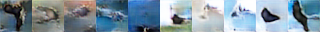

In [0]:
display_png(Image(image_files[0]))

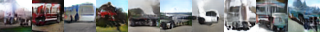

In [0]:
display_png(Image(image_files[-1]))